In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, fbeta_score

import torch
from torch import nn

from Autoencoders import *
from DataPreprocessing import *

# Data preprocessing

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

csv_path = '/content/drive/MyDrive/creditcard.csv'
seed = 777
batch_size = 32
n_splits = 5
# train_loader, test_loader, y_test, input_dim = Data_preprocessing(csv_path, seed, batch_size, n_splits)
splits = Data_preprocessing(csv_path, seed, batch_size, n_splits)

Using device: cpu
Fold 1
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 2
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 3
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 4
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 5
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492


# Train model function

In [ ]:
def train_model(model, dataloader, criterion, optimizer):

    model.train()
    total_loss = 0

    for data, _ in dataloader:
        data = data.to(device)

        if isinstance(model, AutoEncoder):
            decoded = model(data)
            loss = criterion(decoded, data)

        elif isinstance(model, SparseAutoEncoder):
            decoded, encoded = model(data)
            loss = model.sparse_loss(criterion, decoded, data, encoded)

        elif isinstance(model, VariationalAutoEncoder):
            decoded, mu, logvar = model(data)
            loss = model.vae_loss(criterion, decoded, data, mu, logvar)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item() * data.size(0)

    return total_loss / len(dataloader.dataset)


# Evaluate model function

In [ ]:
def evaluate_model(model, dataloader, criterion):

    model.eval()
    total_loss = 0
    all_labels = []
    all_scores = []

    with torch.inference_mode():

        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.cpu().numpy()

            if isinstance(model, AutoEncoder):
                decoded = model(data)
                loss = criterion(decoded, data)
            elif isinstance(model, SparseAutoEncoder):
                decoded, _ = model(data)
                loss = criterion(decoded, data)
            elif isinstance(model, VariationalAutoEncoder):
                decoded, mu, logvar = model(data)
                loss = model.vae_loss(criterion, decoded, data, mu, logvar)

            total_loss += loss.item() * data.size(0)
            all_labels.extend(labels)
            all_scores.extend(loss.cpu().numpy() for _ in range(data.size(0)))

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss, all_labels, all_scores

# XV model funciton

In [ ]:
def cross_validate_model(model_class, splits, learning_rate, epochs, threshold=None):
    fold_train_losses = []
    fold_val_losses = []
    all_labels = []
    all_scores = []

    for fold, (train_loader, val_loader, y_val, input_dim) in enumerate(splits):
        if model_class == SparseAutoEncoder:
            model = model_class(input_dim, sparsity_target=0.1, sparsity_weight=0.1)
        else:
            model = model_class(input_dim)

        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            train_loss = train_model(model, train_loader, criterion, optimizer)
            val_loss, val_labels, val_scores = evaluate_model(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f'Fold {fold + 1}, Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print('\n')

        if threshold is None and fold == 0:
            threshold = np.percentile(val_scores, 95)

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        all_labels.extend(val_labels)
        all_scores.extend(val_scores)

    avg_train_losses = np.mean(fold_train_losses, axis=0)
    std_train_losses = np.std(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)
    std_val_losses = np.std(fold_val_losses, axis=0)

    return avg_train_losses, std_train_losses, avg_val_losses, std_val_losses, all_labels, all_scores, threshold


# Loop for all AutoEncoders and XV

In [ ]:
learning_rate = 0.001
epochs = 7

model_classes = [AutoEncoder, SparseAutoEncoder, VariationalAutoEncoder]
results = {}
train_losses_dict = {}
val_losses_dict = {}
metrics_dict = {}

hard_threshold = None

for model_class in model_classes:
    print(f'\nEvaluating {model_class.__name__}')
    avg_train_losses, std_train_losses, avg_val_losses, std_val_losses, all_labels, all_scores, hard_threshold = cross_validate_model(model_class, splits, learning_rate, epochs, hard_threshold)
    train_losses_dict[model_class.__name__] = (avg_train_losses, std_train_losses)
    val_losses_dict[model_class.__name__] = (avg_val_losses, std_val_losses)

    # Compute basic metrics
    print(hard_threshold)
    predictions = (np.array(all_scores) > hard_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)

    metrics_dict[model_class.__name__] = (accuracy, precision, recall, f1)



Evaluating AutoEncoder
Fold 1, Epoch [1/7], Train Loss: 0.9250, Val Loss: 1.1018
Fold 1, Epoch [2/7], Train Loss: 0.8935, Val Loss: 1.0860
Fold 1, Epoch [3/7], Train Loss: 0.8794, Val Loss: 1.0773
Fold 1, Epoch [4/7], Train Loss: 0.8737, Val Loss: 1.0738
Fold 1, Epoch [5/7], Train Loss: 0.8699, Val Loss: 1.0695
Fold 1, Epoch [6/7], Train Loss: 0.8665, Val Loss: 1.0654
Fold 1, Epoch [7/7], Train Loss: 0.8629, Val Loss: 1.0618


Fold 2, Epoch [1/7], Train Loss: 0.9402, Val Loss: 1.1571
Fold 2, Epoch [2/7], Train Loss: 0.8972, Val Loss: 1.1417
Fold 2, Epoch [3/7], Train Loss: 0.8879, Val Loss: 1.1345
Fold 2, Epoch [4/7], Train Loss: 0.8819, Val Loss: 1.1282
Fold 2, Epoch [5/7], Train Loss: 0.8759, Val Loss: 1.1247
Fold 2, Epoch [6/7], Train Loss: 0.8717, Val Loss: 1.1216
Fold 2, Epoch [7/7], Train Loss: 0.8688, Val Loss: 1.1202


Fold 3, Epoch [1/7], Train Loss: 0.9529, Val Loss: 1.1104
Fold 3, Epoch [2/7], Train Loss: 0.9104, Val Loss: 1.0902
Fold 3, Epoch [3/7], Train Loss: 0.8929, Val

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Evaluating VariationalAutoEncoder
Fold 1, Epoch [1/7], Train Loss: 1.0657, Val Loss: 1.2005
Fold 1, Epoch [2/7], Train Loss: 1.0001, Val Loss: 1.2004
Fold 1, Epoch [3/7], Train Loss: 1.0000, Val Loss: 1.2005
Fold 1, Epoch [4/7], Train Loss: 1.0000, Val Loss: 1.2004
Fold 1, Epoch [5/7], Train Loss: 1.0000, Val Loss: 1.2004
Fold 1, Epoch [6/7], Train Loss: 1.0000, Val Loss: 1.2004
Fold 1, Epoch [7/7], Train Loss: 1.0000, Val Loss: 1.2004


Fold 2, Epoch [1/7], Train Loss: 1.0314, Val Loss: 1.2502
Fold 2, Epoch [2/7], Train Loss: 1.0000, Val Loss: 1.2502
Fold 2, Epoch [3/7], Train Loss: 1.0000, Val Loss: 1.2502
Fold 2, Epoch [4/7], Train Loss: 1.0000, Val Loss: 1.2502
Fold 2, Epoch [5/7], Train Loss: 1.0000, Val Loss: 1.2502
Fold 2, Epoch [6/7], Train Loss: 1.0000, Val Loss: 1.2502
Fold 2, Epoch [7/7], Train Loss: 1.0000, Val Loss: 1.2502


Fold 3, Epoch [1/7], Train Loss: 1.0535, Val Loss: 1.1879
Fold 3, Epoch [2/7], Train Loss: 1.0000, Val Loss: 1.1878
Fold 3, Epoch [3/7], Train Loss: 

In [ ]:
import pickle

# Save the dictionary to a file
with open('metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

# Save the dictionary to a file
with open('train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses_dict, f)

# Save the dictionary to a file
with open('val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses_dict, f)

{'AutoEncoder': (array([0.94147325, 0.90215966, 0.89085899, 0.88439782, 0.87952061,
       0.87616279, 0.8735598 ]), array([0.00934854, 0.00605489, 0.00662923, 0.0066812 , 0.00637123,
       0.00677623, 0.00736265])), 'SparseAutoEncoder': (array([       inf, 0.95023637, 0.92885651, 0.92010054, 0.91474941,
       0.91143672, 0.90813116]), array([       nan, 0.09161365, 0.0853307 , 0.08370301, 0.08256594,
       0.0825724 , 0.08191767])), 'VariationalAutoEncoder': (array([1.04716557, 1.00003344, 1.0000126 , 1.00000335, 1.00000129,
       1.00000069, 1.00000067]), array([1.16139349e-02, 1.88650380e-05, 1.21696918e-05, 2.82156662e-06,
       1.01381906e-06, 1.44726633e-07, 1.48119543e-07]))}


#

In [5]:
import pickle

# Load the dictionary from the file
with open('metrics_dict.pkl', 'rb') as f:
    loaded_metrics_dict = pickle.load(f)

    # Load the dictionary from the file
with open('train_losses.pkl', 'rb') as f:
    loaded_train_losses_dict = pickle.load(f)

    # Load the dictionary from the file
with open('val_losses.pkl', 'rb') as f:
    loaded_val_losses_dict = pickle.load(f)

# Plot losses and metrics

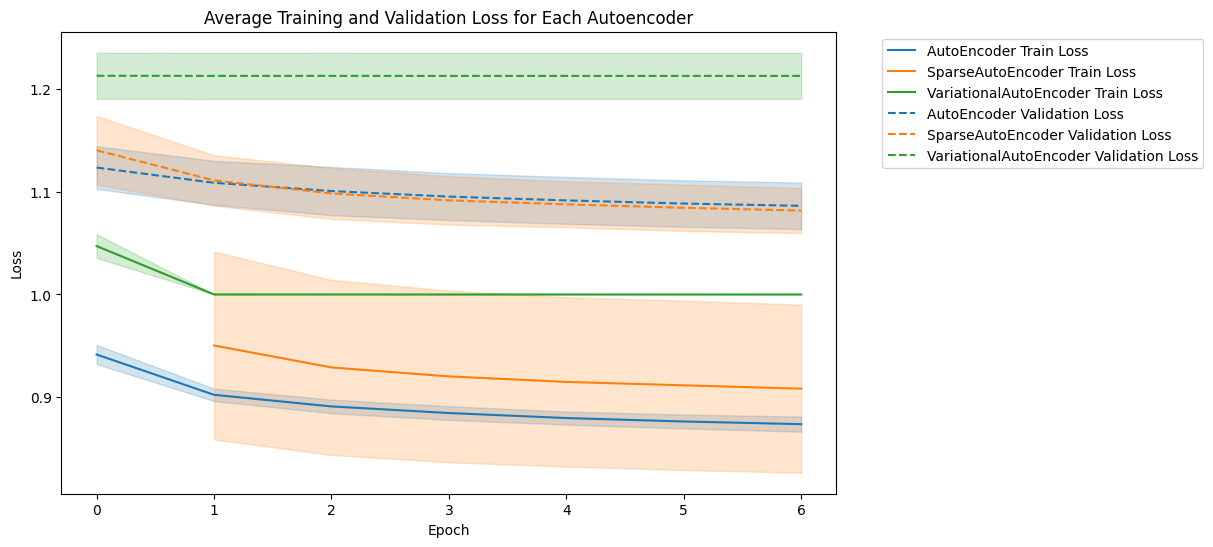

AutoEncoder Metrics:
Accuracy: 0.9575
Precision: 0.1676
Recall: 0.9980
F1 Score: 0.2870

SparseAutoEncoder Metrics:
Accuracy: 0.9578
Precision: 0.1687
Recall: 0.9980
F1 Score: 0.2886

VariationalAutoEncoder Metrics:
Accuracy: 0.9460
Precision: 0.1368
Recall: 0.9980
F1 Score: 0.2407



In [ ]:
# Plot training and validation losses for each autoencoder
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default color cycle

for i, (model_name, (avg_losses, std_losses)) in enumerate(loaded_train_losses_dict.items()):
    epochs = range(len(avg_losses))
    plt.plot(epochs, avg_losses, color=colors[i], label=f'{model_name} Train Loss')
    plt.fill_between(epochs, np.array(avg_losses) - np.array(std_losses), np.array(avg_losses) + np.array(std_losses), color=colors[i], alpha=0.2)

for i, (model_name, (avg_losses, std_losses)) in enumerate(loaded_val_losses_dict.items()):
    epochs = range(len(avg_losses))
    plt.plot(epochs, avg_losses, color=colors[i], linestyle='--', label=f'{model_name} Validation Loss')
    plt.fill_between(epochs, np.array(avg_losses) - np.array(std_losses), np.array(avg_losses) + np.array(std_losses), color=colors[i], alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss for Each Autoencoder')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Print average metrics for each autoencoder
for model_name, (accuracy, precision, recall, f1) in loaded_metrics_dict.items():
    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}\n')

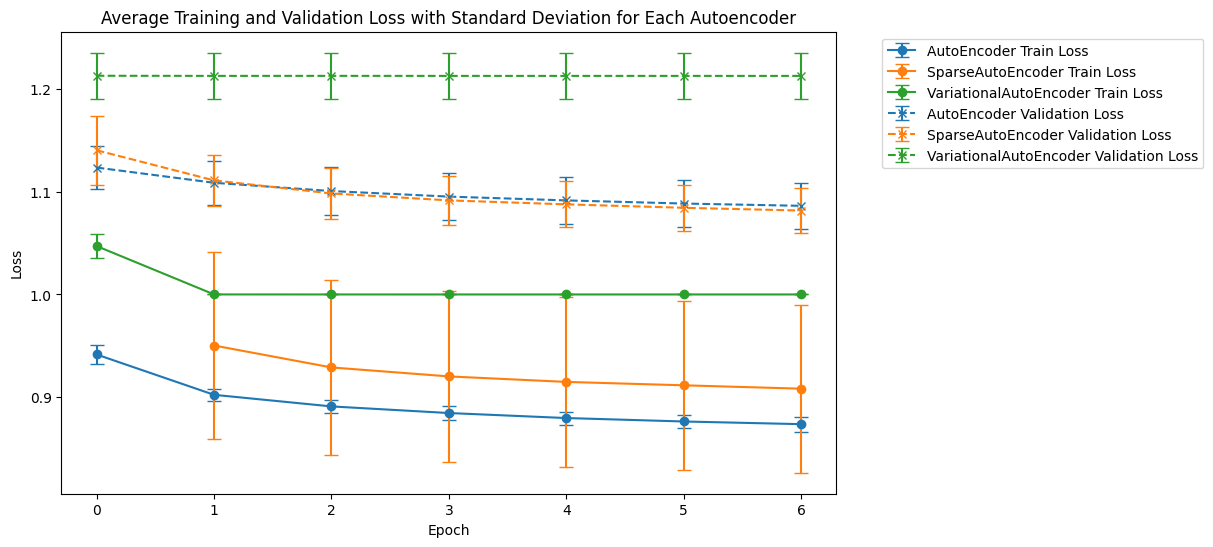

In [ ]:
# Plot training and validation losses for each autoencoder with error bars
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default color cycle

for i, (model_name, (avg_losses, std_losses)) in enumerate(loaded_train_losses_dict.items()):
    epochs = range(len(avg_losses))
    plt.errorbar(epochs, avg_losses, yerr=std_losses, color=colors[i], label=f'{model_name} Train Loss', capsize=5, linestyle='-', marker='o')

for i, (model_name, (avg_losses, std_losses)) in enumerate(loaded_val_losses_dict.items()):
    epochs = range(len(avg_losses))
    plt.errorbar(epochs, avg_losses, yerr=std_losses, color=colors[i], label=f'{model_name} Validation Loss', capsize=5, linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss with Standard Deviation for Each Autoencoder')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

# Extract the validation losses for AutoEncoder and SparseAutoEncoder
autoencoder_val_losses = loaded_val_losses_dict['AutoEncoder'][0]
sparse_val_losses = loaded_val_losses_dict['SparseAutoEncoder'][0]

# Paired t-test
t_stat, p_value_ttest = ttest_rel(autoencoder_val_losses, sparse_val_losses)
print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_ttest:.4f}")

# Wilcoxon signed-rank test
w_stat, p_value_wilcoxon = wilcoxon(autoencoder_val_losses, sparse_val_losses)
print(f"Wilcoxon signed-rank test: statistic = {w_stat:.4f}, p-value = {p_value_wilcoxon:.4f}")

Paired t-test: t-statistic = -0.0254, p-value = 0.9806
Wilcoxon signed-rank test: statistic = 8.0000, p-value = 0.3750


Both the paired t-test and the Wilcoxon signed-rank test indicate that there is no statistically significant difference between the validation losses of the AutoEncoder and SparseAutoEncoder. In other words, based on the validation loss data, we cannot conclude that one model performs significantly better than the other.

In [4]:
# Initialize lists to store cross-validation results
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Cross-validation loop
for i, (train_loader, val_loader, y_val, input_size) in enumerate(splits):
    # Extract training data
    X_train = []
    for data in train_loader:
        X_train.append(data[0].numpy())
    X_train = np.concatenate(X_train)

    # Extract validation data
    X_val = []
    y_val_list = []
    for data in val_loader:
        X_val.append(data[0].numpy())
        y_val_list.extend(data[1].numpy())
    X_val = np.concatenate(X_val)
    y_val = np.array(y_val_list)

    # Train One-Class SVM
    model = OneClassSVM(kernel='rbf', nu=0.006, gamma='auto')
    model.fit(X_train)

    # Predict validation data
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred == 1, 0, 1)  # Convert labels to match 0 for normal and 1 for fraud

    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=1)
    recall = recall_score(y_val, y_pred, zero_division=1)
    f1 = f1_score(y_val, y_pred, zero_division=1)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Fold {i+1}:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")

# Calculate and print mean metrics
mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)

print("\nCross-Validation Results:")
print(f"  Mean Accuracy: {mean_accuracy}")
print(f"  Mean Precision: {mean_precision}")
print(f"  Mean Recall: {mean_recall}")
print(f"  Mean F1 Score: {mean_f1}")

Fold 1:
  Accuracy: 0.9872548164937669
  Precision: 0.38431752178121975
  Recall: 0.806910569105691
  F1 Score: 0.520655737704918
Fold 2:
  Accuracy: 0.9881265800714846
  Precision: 0.40307692307692305
  Recall: 0.7987804878048781
  F1 Score: 0.5357873210633947
Fold 3:
  Accuracy: 0.9881963211577021
  Precision: 0.4066599394550959
  Recall: 0.8191056910569106
  F1 Score: 0.5434929197572489
Fold 4:
  Accuracy: 0.9855287246098858
  Precision: 0.35175438596491226
  Recall: 0.8150406504065041
  F1 Score: 0.491421568627451
Fold 5:
  Accuracy: 0.987411733937756
  Precision: 0.3883495145631068
  Recall: 0.8130081300813008
  F1 Score: 0.5256241787122208

Cross-Validation Results:
  Mean Accuracy: 0.987303635254119
  Mean Precision: 0.3868316569682516
  Mean Recall: 0.8105691056910569
  Mean F1 Score: 0.5233963451730467


In [18]:
# Utilizing F-beta score
betas = [0.25, 0.5, 1, 2, 4, 8]

def calculate_fbeta(precision, recall, beta=1.0):
    return (1 + np.power(beta,2)) * (precision * recall) / (np.power(beta,2) * precision + recall)


f_beta_scores = {model_name: [] for model_name in loaded_metrics_dict.keys()}
SVM_scores = []

for b in betas:
  print(f'F-beta scores for beta = {b}:')

  fbeta = calculate_fbeta(mean_precision, mean_recall, beta=b)
  print(f'OC-SVM: {fbeta:.4f}')
  SVM_scores.append(fbeta)

  for model_name, (accuracy, precision, recall, f1) in loaded_metrics_dict.items():
      fbeta = calculate_fbeta(precision, recall, beta=b)
      print(f'{model_name}: {fbeta:.4f}')
      f_beta_scores[model_name].append(fbeta)
  print()

F-beta scores for beta = 0.25:
OC-SVM: 0.3991
AutoEncoder: 0.1762
SparseAutoEncoder: 0.1774
VariationalAutoEncoder: 0.1441

F-beta scores for beta = 0.5:
OC-SVM: 0.4320
AutoEncoder: 0.2011
SparseAutoEncoder: 0.2023
VariationalAutoEncoder: 0.1654

F-beta scores for beta = 1:
OC-SVM: 0.5237
AutoEncoder: 0.2870
SparseAutoEncoder: 0.2886
VariationalAutoEncoder: 0.2407

F-beta scores for beta = 2:
OC-SVM: 0.6649
AutoEncoder: 0.5013
SparseAutoEncoder: 0.5033
VariationalAutoEncoder: 0.4418

F-beta scores for beta = 4:
OC-SVM: 0.7615
AutoEncoder: 0.7728
SparseAutoEncoder: 0.7741
VariationalAutoEncoder: 0.7283

F-beta scores for beta = 8:
OC-SVM: 0.7971
AutoEncoder: 0.9273
SparseAutoEncoder: 0.9278
VariationalAutoEncoder: 0.9099



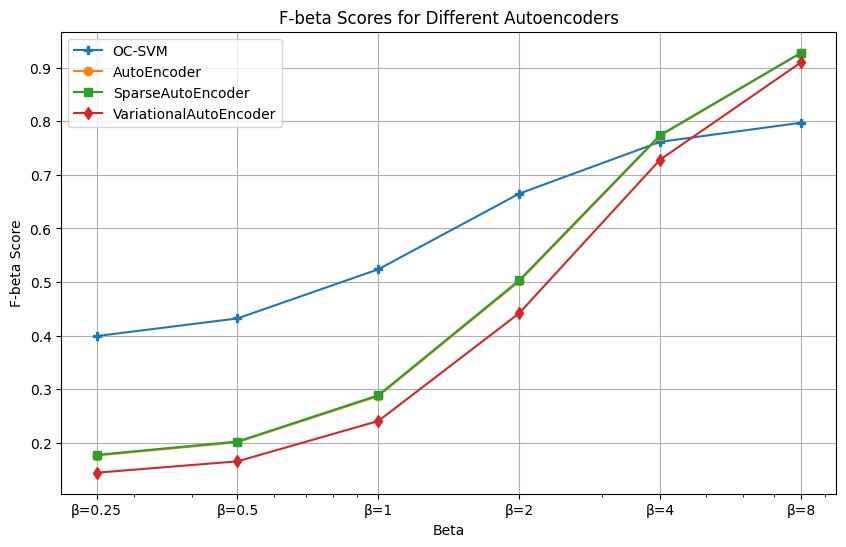

In [22]:


# Provided F-beta scores for each model
f_beta_autoencoder = f_beta_scores.get('AutoEncoder', [])
f_beta_sparse = f_beta_scores.get('SparseAutoEncoder', [])
f_beta_variational = f_beta_scores.get('VariationalAutoEncoder', [])
f_beta_svm = SVM_scores
# Plotting the F-beta scores
plt.figure(figsize=(10, 6))
plt.plot(betas, f_beta_svm, marker='P', label='OC-SVM')
plt.plot(betas, f_beta_autoencoder, marker='o', label='AutoEncoder')
plt.plot(betas, f_beta_sparse, marker='s', label='SparseAutoEncoder')
plt.plot(betas, f_beta_variational, marker='d', label='VariationalAutoEncoder')

# Adding plot details
plt.xlabel('Beta')
plt.ylabel('F-beta Score')
plt.title('F-beta Scores for Different Autoencoders')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use logarithmic scale for beta
plt.xticks(betas, labels=[f'β={b}' for b in betas])  # Custom ticks for readability

# Show plot
plt.show()